<h1 style="color:red; font-family: 'Helvetica Neue', sans-serif; font-size:40px; text-align: center; font-weight:bold; font-style:italic">Rice Leaf Disease: Image Classification</h1>

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Installing Modules</h1>

In [56]:
!pip install keras -tuner

  Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.14.0 which is incompatible.


In [57]:
!pip install -q -U keras-tuner

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Importing Libraries</h1>

In [58]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
import kerastuner as kt
from kerastuner.tuners import RandomSearch

#transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

we are currently using tensorflow version 2.13.0


In [59]:
from google.colab import drive

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Setting up an environment</h1>

In [60]:
input_shape_2D=(299,299)
input_shape_3D= (299, 299, 3)
seed=1
batch_size=32
epochs=30
stopper=EarlyStopping(patience=5)

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Uploading image dataset</h1>



In [61]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/megakill/archive',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 240 files belonging to 3 classes.


In [63]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['blast', 'blight', 'tungro']


In [64]:
print(class_names)

['blast', 'blight', 'tungro']


In [65]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

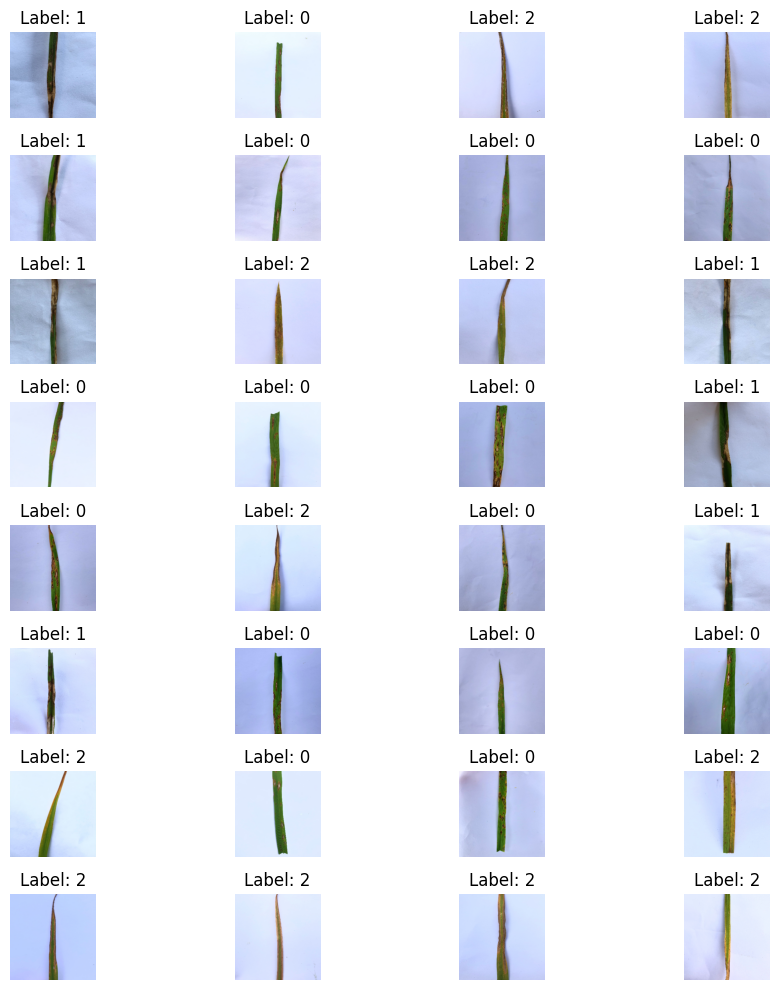

In [66]:
#displaying image batch of 32
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Data Processing</h1>

In [67]:
X=[]
y= []

for image, label in data_ds.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [68]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [69]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

# Normalisation

In [70]:
X_train = X_train/255
X_test = X_test/255

In [71]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (180, 299, 299, 3)
shape of y_train: (180,)
shape of X_test_scaled: (60, 299, 299, 3)
shape of y_test: (60,)


# Encoding

In [72]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">CNN Architecture</h1>

In [73]:
own_model=Sequential()

# adding first convloutional layer
own_model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape_3D))
own_model.add(MaxPooling2D())

# adding second convloutional layer
own_model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding third convloutional layer
own_model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding flatten layer
own_model.add(Flatten())

# adding fully connected layers
own_model.add(Dense(200, activation='relu'))

#adding output layer : number of classes are 3
own_model.add(Dense(3, activation='softmax'))


In [74]:
# compiling model
own_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
checkpointer_own = ModelCheckpoint(filepath='own_weights.h5',
                                    save_best_only=True)

Epoch 1/30
6/6 [==============================] - 1s 113ms/step - loss: 1.3863e-04 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9333
Epoch 2/30
6/6 [==============================] - 0s 64ms/step - loss: 1.3135e-04 - accuracy: 1.0000 - val_loss: 0.2889 - val_accuracy: 0.9333
Epoch 3/30
6/6 [==============================] - 0s 67ms/step - loss: 1.2803e-04 - accuracy: 1.0000 - val_loss: 0.2961 - val_accuracy: 0.9333
Epoch 4/30
6/6 [==============================] - 0s 65ms/step - loss: 1.2985e-04 - accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 0.9333
Epoch 5/30
6/6 [==============================] - 0s 68ms/step - loss: 1.2410e-04 - accuracy: 1.0000 - val_loss: 0.3085 - val_accuracy: 0.9333
Epoch 6/30
6/6 [==============================] - 0s 66ms/step - loss: 1.1136e-04 - accuracy: 1.0000 - val_loss: 0.2796 - val_accuracy: 0.9333
Epoch 7/30
6/6 [==============================] - 0s 68ms/step - loss: 1.1962e-04 - accuracy: 1.0000 - val_loss: 0.3002 - val_accuracy: 0.933

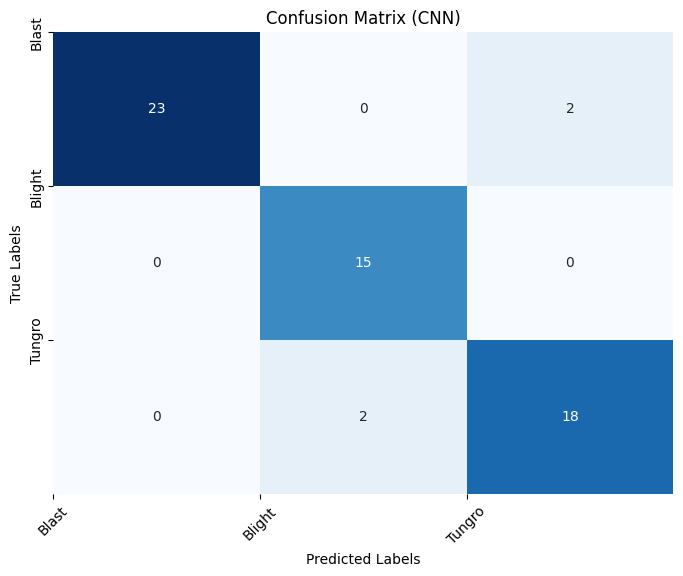

Accuracy for class Blast: 0.92
Accuracy for class Blight: 1.00
Accuracy for class Tungro: 0.90
Average Accuracy: 0.94
Precision for class Blast: 1.00
Recall for class Blast: 0.92
F1 Score for class Blast: 0.96
Specificity for class Blast: 0.38
Precision for class Blight: 0.88
Recall for class Blight: 1.00
F1 Score for class Blight: 0.94
Specificity for class Blight: 0.64
Precision for class Tungro: 0.90
Recall for class Tungro: 0.90
F1 Score for class Tungro: 0.90
Specificity for class Tungro: 0.51


In [103]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Train your CNN model and obtain predictions
cnn_history = own_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[stopper, checkpointer_own])

# Calculate confusion matrix
y_pred_cnn = own_model.predict(X_test)
y_true_cnn = np.argmax(y_test, axis=1)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

class_names = ['Blast', 'Blight', 'Tungro']  # Nama kelas

confusion_mat_cnn = confusion_matrix(y_true_cnn, y_pred_cnn_classes)

# Calculate accuracy for each class
class_acc_cnn = confusion_mat_cnn.diagonal() / confusion_mat_cnn.sum(axis=1)

# Calculate average accuracy
average_acc = np.mean(class_acc_cnn)

# Calculate precision, recall, F1-score, and specificity using scikit-learn
classification_rep = classification_report(y_true_cnn, y_pred_cnn_classes, target_names=class_names, output_dict=True)

# Display confusion matrix with accuracy for each class
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (CNN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.show()

# Display accuracy for each class
for i, acc in enumerate(class_acc_cnn):
    print(f'Accuracy for class {class_names[i]}: {acc:.2f}')

# Display average accuracy
print(f'Average Accuracy: {average_acc:.2f}')

# Display precision, recall, F1 score, and specificity
for class_name in class_names:
    precision = classification_rep[class_name]['precision']
    recall = classification_rep[class_name]['recall']
    f1_score = classification_rep[class_name]['f1-score']
    specificity = (classification_rep['Blast']['support'] + classification_rep['Blight']['support'] - classification_rep[class_name]['support']) / (classification_rep['Blast']['support'] + classification_rep['Blight']['support'] - 1)

    print(f'Precision for class {class_name}: {precision:.2f}')
    print(f'Recall for class {class_name}: {recall:.2f}')
    print(f'F1 Score for class {class_name}: {f1_score:.2f}')
    print(f'Specificity for class {class_name}: {specificity:.2f}')

In [104]:
print("Classification Report (CNN):")
print(confusion_mat_cnn)

Classification Report (CNN):
[[23  0  2]
 [ 0 15  0]
 [ 0  2 18]]


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Transfer Learning</h1>

## InceptionV3

In [81]:
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint

# Create an InceptionV3 model
inception_model = InceptionV3()

# Compile the model, set the optimizer and loss function, and then fit the model
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the InceptionV3 model during training
checkpointer_inception = ModelCheckpoint(filepath='inception_model_weights.h5',
                                          save_best_only=True)


Epoch 1/30
6/6 [==============================] - 8s 611ms/step - loss: 2.8278 - accuracy: 0.4111 - val_loss: 2.4964 - val_accuracy: 0.5333
Epoch 2/30
6/6 [==============================] - 2s 297ms/step - loss: 1.3158 - accuracy: 0.7111 - val_loss: 0.3665 - val_accuracy: 0.8833
Epoch 3/30
6/6 [==============================] - 1s 175ms/step - loss: 0.4514 - accuracy: 0.8111 - val_loss: 0.2888 - val_accuracy: 0.8833
Epoch 4/30
6/6 [==============================] - 1s 185ms/step - loss: 0.2754 - accuracy: 0.9111 - val_loss: 0.2889 - val_accuracy: 0.8667
Epoch 5/30
6/6 [==============================] - 2s 358ms/step - loss: 0.1643 - accuracy: 0.9611 - val_loss: 0.2727 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 2s 363ms/step - loss: 0.1135 - accuracy: 0.9833 - val_loss: 0.1968 - val_accuracy: 0.9167
Epoch 7/30
6/6 [==============================] - 1s 182ms/step - loss: 0.1043 - accuracy: 0.9722 - val_loss: 0.2328 - val_accuracy: 0.9000
Epoch 8/30
6/6 [====

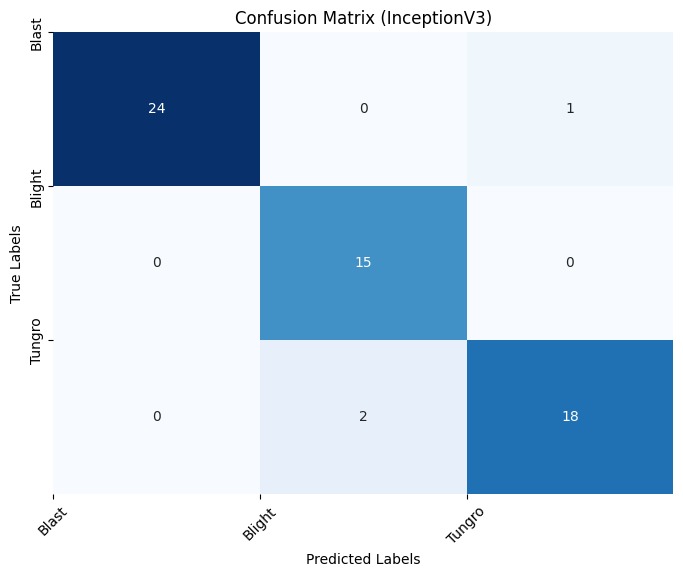

Accuracy for class Blast: 0.96
Accuracy for class Blight: 1.00
Accuracy for class Tungro: 0.90
Average Accuracy: 0.95
{'Blast': {'precision': 1.0, 'recall': 0.96, 'f1-score': 0.9795918367346939, 'support': 25}, 'Blight': {'precision': 0.8823529411764706, 'recall': 1.0, 'f1-score': 0.9375, 'support': 15}, 'Tungro': {'precision': 0.9473684210526315, 'recall': 0.9, 'f1-score': 0.9230769230769231, 'support': 20}, 'accuracy': 0.95, 'macro avg': {'precision': 0.9432404540763674, 'recall': 0.9533333333333333, 'f1-score': 0.9467229199372057, 'support': 60}, 'weighted avg': {'precision': 0.9530443756449948, 'recall': 0.95, 'f1-score': 0.9502305729984303, 'support': 60}}


In [110]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint  # Tambahkan import ini
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers for your three-class classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes

# Create a new model
inception_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the appropriate loss and optimizer
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up ModelCheckpoint to save the best model
checkpointer_inception = ModelCheckpoint(filepath='inception_best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train your model with the data
inception_history = inception_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpointer_inception])

# Load the best model
from tensorflow.keras.models import load_model

best_inception_model = load_model('inception_best_model.h5')

# Calculate confusion matrix
y_pred_inception = best_inception_model.predict(X_test)
y_true_inception = np.argmax(y_test, axis=1)
y_pred_inception_classes = np.argmax(y_pred_inception, axis=1)

class_names = ['Blast', 'Blight', 'Tungro']  # Nama kelas

confusion_mat_inception = confusion_matrix(y_true_inception, y_pred_inception_classes)

# Calculate accuracy for each class
class_acc_inception = confusion_mat_inception.diagonal() / confusion_mat_inception.sum(axis=1)

# Calculate average accuracy
average_acc = np.mean(class_acc_inception)

# Display confusion matrix with accuracy for each class
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_inception, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (InceptionV3)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.show()

# Display accuracy for each class
for i, acc in enumerate(class_acc_inception):
    print(f'Accuracy for class {class_names[i]}: {acc:.2f}')

# Display average accuracy
print(f'Average Accuracy: {average_acc:.2f}')

# Calculate precision, recall, F1-score, and specificity using scikit-learn
classification_rep = classification_report(y_true_inception, y_pred_inception_classes, target_names=class_names, output_dict=True)
print(classification_rep)

In [111]:
print("Classification Report (InceptionV3):")
print(confusion_mat_inception)

Classification Report (InceptionV3):
[[24  0  1]
 [ 0 15  0]
 [ 0  2 18]]


## Xception

Epoch 1/30
6/6 [==============================] - 9s 570ms/step - loss: 0.5394 - accuracy: 0.7944 - val_loss: 0.3780 - val_accuracy: 0.8000
Epoch 2/30
6/6 [==============================] - 2s 317ms/step - loss: 0.2090 - accuracy: 0.9278 - val_loss: 0.1385 - val_accuracy: 0.9667
Epoch 3/30
6/6 [==============================] - 2s 313ms/step - loss: 0.0996 - accuracy: 0.9611 - val_loss: 0.1248 - val_accuracy: 0.9333
Epoch 4/30
6/6 [==============================] - 2s 339ms/step - loss: 0.0340 - accuracy: 0.9944 - val_loss: 0.0924 - val_accuracy: 0.9833
Epoch 5/30
6/6 [==============================] - 2s 297ms/step - loss: 0.0232 - accuracy: 0.9944 - val_loss: 0.0848 - val_accuracy: 0.9667
Epoch 6/30
6/6 [==============================] - 2s 290ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0844 - val_accuracy: 0.9500
Epoch 7/30
6/6 [==============================] - 2s 293ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0736 - val_accuracy: 0.9833
Epoch 8/30
6/6 [====

2/2 [==============================] - 1s 250ms/step


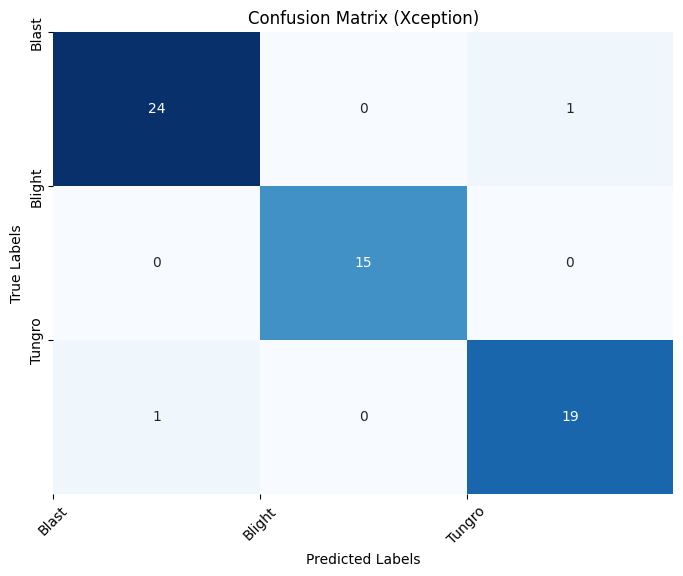

Accuracy for class Blast: 0.96
Accuracy for class Blight: 1.00
Accuracy for class Tungro: 0.95
Average Accuracy: 0.97
              precision    recall  f1-score   support

       Blast       0.96      0.96      0.96        25
      Blight       1.00      1.00      1.00        15
      Tungro       0.95      0.95      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [93]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers for your three-class classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes

# Create a new model
xception_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the appropriate loss and optimizer
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train your model with the data
xception_history = xception_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[stopper, checkpointer_xception])

# Calculate confusion matrix
y_pred_xception = xception_model.predict(X_test)
y_true_xception = np.argmax(y_test, axis=1)
y_pred_xception_classes = np.argmax(y_pred_xception, axis=1)

class_names = ['Blast', 'Blight', 'Tungro']  # Nama kelas

confusion_mat_xception = confusion_matrix(y_true_xception, y_pred_xception_classes)

# Calculate accuracy for each class
class_acc_xception = confusion_mat_xception.diagonal() / confusion_mat_xception.sum(axis=1)

# Calculate average accuracy
average_acc = np.mean(class_acc_xception)

# Display confusion matrix with accuracy for each class
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_xception, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Xception)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.show()

# Display accuracy for each class
for i, acc in enumerate(class_acc_xception):
    print(f'Accuracy for class {class_names[i]}: {acc:.2f}')

# Display average accuracy
print(f'Average Accuracy: {average_acc:.2f}')

# Calculate precision, recall, F1-score, and support using scikit-learn
class_report = classification_report(y_true_xception, y_pred_xception_classes, target_names=class_names)
print(class_report)


In [108]:
print("Classification Report (Xception):")
print(confusion_mat_xception)

Classification Report (Xception):
[[24  0  1]
 [ 0 15  0]
 [ 1  0 19]]


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Loading Best Model</h1>

In [84]:
inception_model.load_weights('inception_best_model.h5')

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Visualising Kernels</h1>

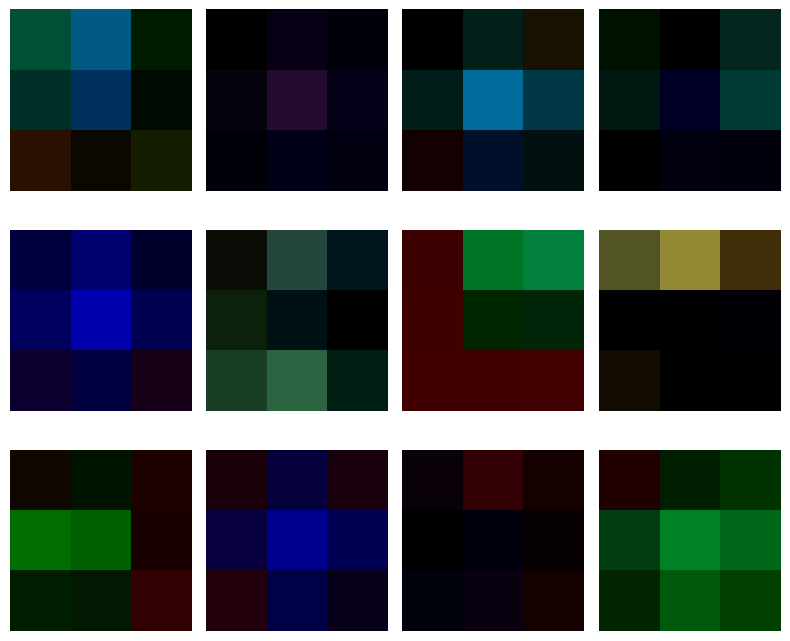

In [85]:
fig, axs = plt.subplots(3, 4, figsize=(8, 8))

# Ambil lapisan konvolusi pertama
conv1 = inception_model.layers[1]

# Dapatkan bobot dari lapisan konvolusi pertama
weights1 = conv1.get_weights()[0]

for i, ax in zip(range(12), axs.flatten()):
    kernel1_1 = weights1[:, :, :, i]
    ax.imshow(kernel1_1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    ax.axis('off')


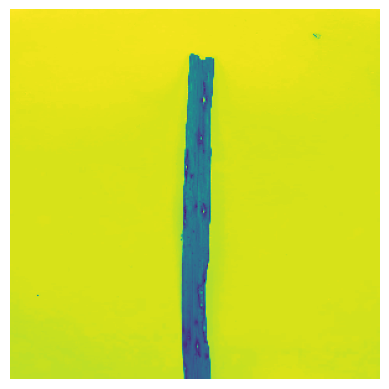

In [86]:
image = tf.keras.utils.load_img('/content/drive/MyDrive/megakill/archive/blast/IMG_0722.jpg', target_size=input_shape_2D)
input_arr = tf.keras.utils.img_to_array(image)/255
image = input_arr[:, :, 1]
plt.imshow(image)
plt.axis('off');

In [87]:
import numpy as np

def convolution(image, kernel):
    # Get the size of the kernel
    kernel_size = kernel.shape[0]

    # Calculate the size of the output image
    output_size = image.shape[0] - kernel_size + 1

    # Initialize the output image
    output_image = np.zeros((output_size, output_size))

    # Pad the image with zeros
    padded_image = np.pad(image, ((kernel_size-1)//2, (kernel_size-1)//2), 'constant')

    # Apply the convolution operation
    for ii in range(output_size):
        for jj in range(output_size):
            window = padded_image[ii:ii+kernel_size, jj:jj+kernel_size]
            output_image[ii, jj] = np.sum(window * kernel)

    return output_image


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Visualising Prediction</h1>


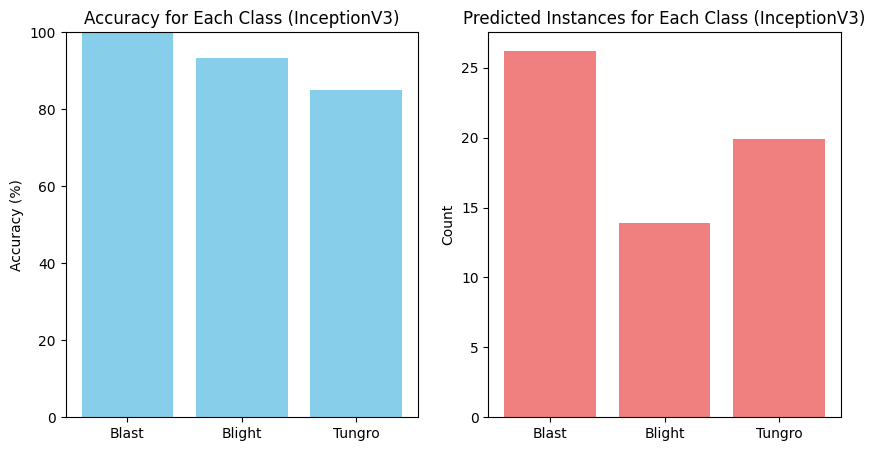

In [88]:
# Visualizing predictions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(class_names, class_acc_inception * 100, color='skyblue')
plt.title('Accuracy for Each Class (InceptionV3)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

plt.subplot(1, 2, 2)
plt.bar(class_names, y_pred_inception.sum(axis=0), color='lightcoral')
plt.title('Predicted Instances for Each Class (InceptionV3)')
plt.ylabel('Count')
plt.show()

In [89]:
# get predictions on the test set
y_hat = best_inception_model.predict(X_test)

# define text labels
labels = data_ds.class_names

2/2 [==============================] - 0s 167ms/step


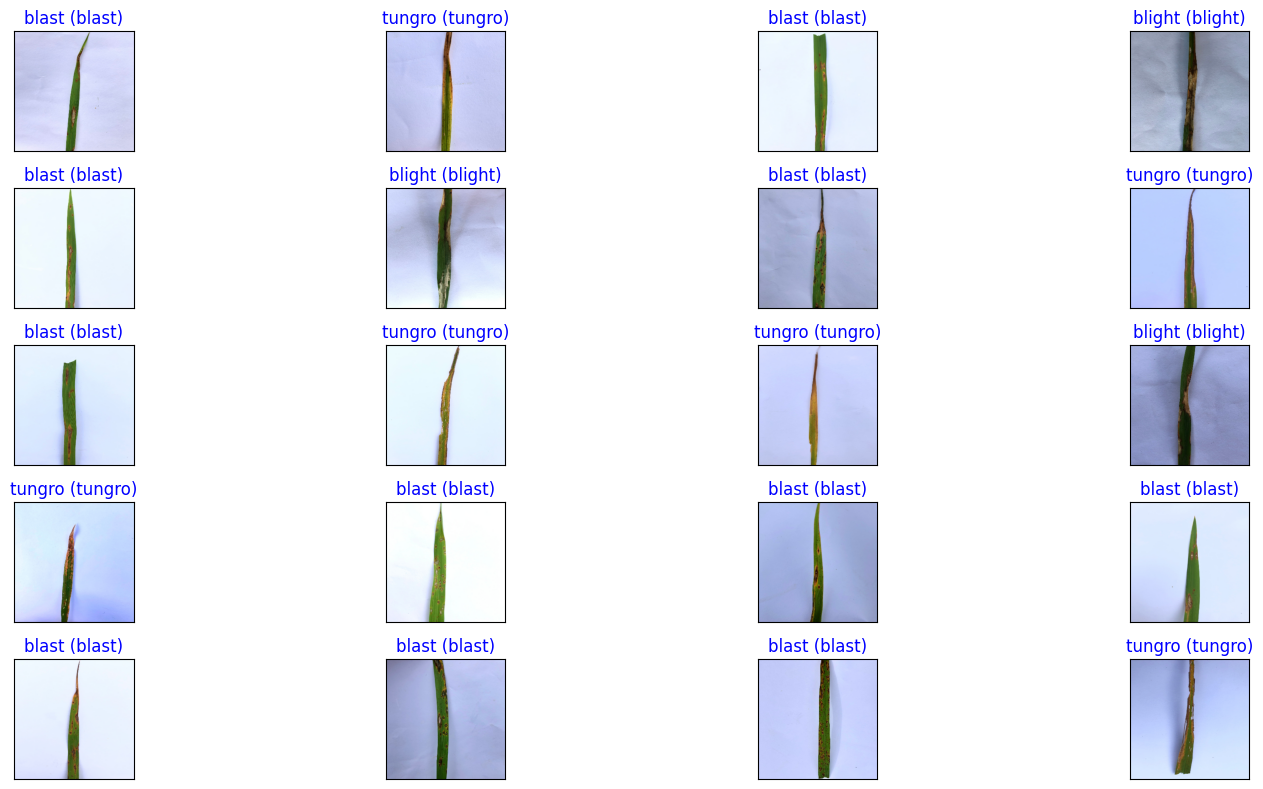

In [90]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
    plt.tight_layout()

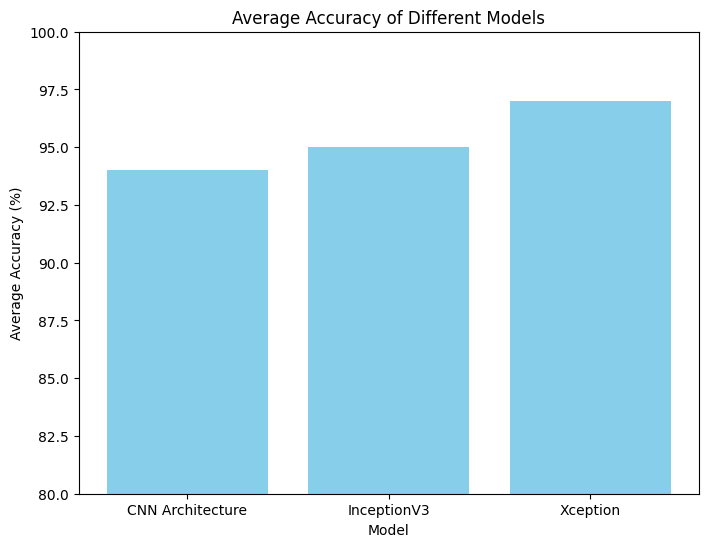

In [113]:
import matplotlib.pyplot as plt

# Data akurasi dari tabel (diubah menjadi persen)
model_names = ['CNN Architecture', 'InceptionV3', 'Xception']
accuracies = [94, 95, 97]  # Akurasi diubah menjadi persen

# Membuat grafik batang
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Average Accuracy (%)')
plt.title('Average Accuracy of Different Models')
plt.ylim(80, 100)  # Sesuaikan dengan rentang akurasi dalam persen
plt.show()
